# 1. Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')


%matplotlib inline

from numpy.linalg import inv
from numpy.random import multivariate_normal, exponential
import statsmodels.formula.api as smf
from scipy import stats

from sklearn.base import RegressorMixin, BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from progressbar import ProgressBar
from lazy import lazy
from tabulate import tabulate

This `AwesomeLinearModel` is a class I wrote years ago for Econometrics class. It calculates all the quantities we need for the following questions, so I decided to use it.

In [2]:
class AwesomeLinearModel(RegressorMixin, BaseEstimator, TransformerMixin):

    def __init__(self):
        super(AwesomeLinearModel, self).__init__()
        self.x_names, self.y_name = None, None
        self.n, self.p = None, None
        self.formula = 'LinearModel( )\n'
        self.fitted = False

        # algebraic properties
        self.X, self.y = None, None
        self.XtX = None
        self.XtX_inv = None
        self.b_hat = None
        self.HX = None
        self.residuals = None  # n*1
        self.RSS = None

        # statistical properties
        self.sigma_sq_mle = None
        self.sigma_sq_unbiased = None
        self.rse = None
        self.cov_b = None
        self.var_b = None
        self.std_b = None
        self.t_stats = None
        self.p_val = None

    def __repr__(self):
        _repr, rows = self.formula, []
        if not self.fitted:
            return _repr
        for i, s in enumerate(self.x_names):
            rows.append([
                s, self.b_hat[i], self.std_b[i],
                self.t_stats[i], self.p_val[i]])
        _repr += tabulate(
            rows, headers=['', 'Estimate', 'Std.Error',
                           't.Stat', 'p.value'])
        return _repr

    def fit(self, X, y):
        """
        Fit the model.
        :param X: features set.
        :param y: response variable set.
        :return:
        """
        n, p = X.shape
        if self.x_names is None:
            self.x_names = ['X%d'%i for i in range(1,p+1)]
            self.y_name = 'Y'
            formula = 'Y ~ %s' % ' + '.join(self.x_names)
            self.formula = 'LinearModel( {} )\n'.format(formula)
            
        # algebraic properties
        self.X, self.y = X, y
        self.XtX = X.T.dot(X)
        self.XtX_inv = inv(self.XtX)
        self.b_hat = self.XtX_inv.dot(X.T.dot(y))
        self.HX = X.dot(self.XtX_inv).dot(X.T)
        self.residuals = y - X.dot(self.b_hat)  # n*1
        self.RSS = sum([r[0] * r[0] for r in self.residuals])

        # statistical properties
        self.sigma_sq_mle = self.RSS / n
        self.sigma_sq_unbiased = self.RSS / (n - p)
        self.rse = np.sqrt(self.sigma_sq_unbiased)
        self.cov_b = self.XtX_inv * self.sigma_sq_unbiased
        self.var_b = np.diag(self.cov_b).reshape(p, 1)
        self.std_b = np.sqrt(self.var_b).reshape(p, 1)
        self.t_stats = self.b_hat / self.std_b
        self.p_val = (stats.t.sf(
            np.abs(self.t_stats), n - p) * 2).reshape(p, 1)

        self.fitted = True
        return self

    def predict(self, X_test):
        return X_test.dot(self.b_hat)

    @property
    def coef(self):
        return self.b_hat


# 2. Linear Regression with Correlation

In [3]:
def lr_correlated_variables(rho_range, true_beta, 
                            n_sample=1000, test_portion=0.5):
    # initialization
    lr_model = AwesomeLinearModel()
    mse_path, var_path = [], []

    for rho in rho_range:
        # simulate independent X, epsilon 
        X = multivariate_normal(
            np.array([0,0]),
            np.array([[1,rho],[rho,1]]),
            size=n_sample
        )
        epsilon = multivariate_normal(
            np.array([0]),np.array([[1]]),n_sample)
        # generate y
        y = X.dot(beta_dgp) + epsilon

        # train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_portion, random_state=42)

        # fit model, store the quantities we want
        lr_model.fit(X_train,y_train)
        y_pred = lr_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        var_beta1 = lr_model.var_b[0][0]
        var_path.append(var_beta1)
        mse_path.append(mse)
    return rho_range, var_path, mse_path

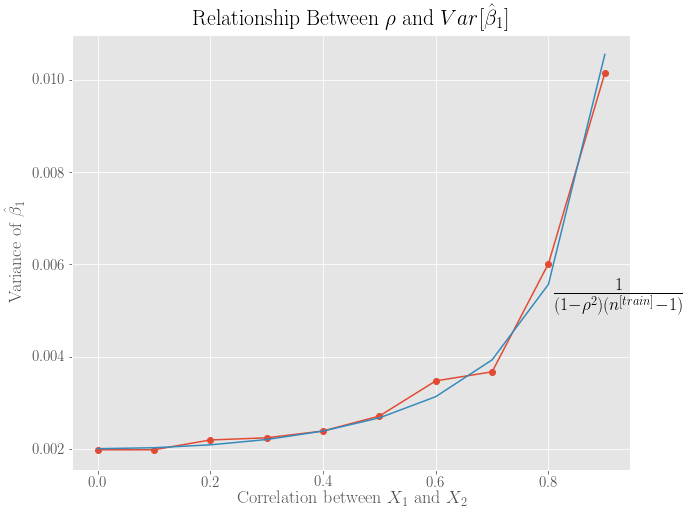

In [55]:
np.random.seed(42)
# run simulation
rho_range, var_path, mse_path = lr_correlated_variables(
    np.linspace(0,0.9,10), 
    np.array([1,1]).reshape(2,1),
    1000, 0.5)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(rho_range, var_path, 'o-')
ax.plot(rho_range, 1/((1-rho_range**2)*499))
ax.set_xlabel('Correlation between $X_1$ and $X_2$')
ax.set_ylabel('Variance of $\hat{\\beta}_1$')
ax.set_title('Relationship Between $\\rho$ and $Var[\hat{\\beta}_1]$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.text(0.81, 0.005, r'$\frac{1}{(1-\rho^2)(n^{[train]}-1)}$', size=25)

It can be shown that the estimated variance of $\hat{β}_j$ can be equivalently expressed as
$$
\hat{Var}[\hat{\beta_j}] = \frac{\hat{\sigma}^2_{\epsilon}}{(n-1)\hat{Var}[X_j]} \frac{1}{(1-R^2_j)}
$$
Which turns out to be
$$
\hat{Var}[\hat{\beta_j}] = \frac{1}{(1-\rho^2)(n^{[\text{train}]}-1)}
$$
in this problem. So we see the simulation results agree to the blue line.

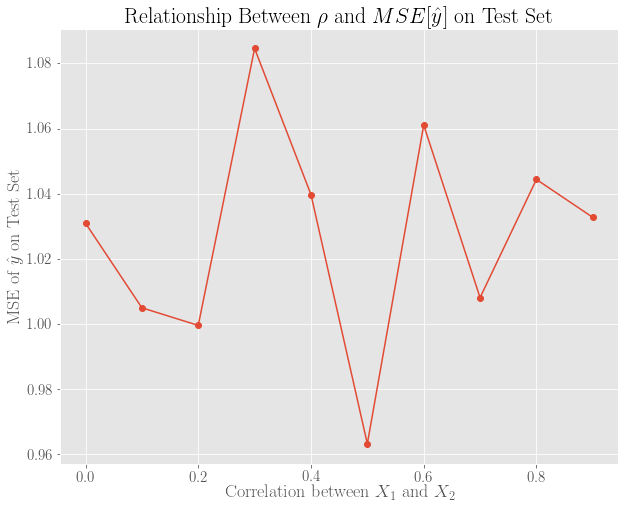

In [51]:
# another plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(rho_range, mse_path, 'o-')
ax.set_xlabel('Correlation between $X_1$ and $X_2$')
ax.set_ylabel('MSE of $\hat{y}$ on Test Set')
ax.set_title('Relationship Between $\\rho$ and $MSE[\hat{y}]$ on Test Set')

There is no strong relationship between $\rho$ and the prediction error, measured by the mean squared error of $\hat{y}$ on the test set.

## 3. Linear Regression in Dimensions

In [106]:
X =  multivariate_normal(
                np.zeros(3),
                np.identity(3),
                10
            )
X[:,0:1]

array([[ 0.28018636],
       [ 0.10307429],
       [-0.779272  ],
       [-1.23021135],
       [ 1.21176011],
       [ 0.16747375],
       [-0.67725433],
       [ 1.03296001],
       [-0.00371641],
       [-0.89865235]])

In [4]:
def lr_high_dimensions(dim_range, beta_dgp, n_epochs=100,
                       n_sample=1000, test_portion=0.5):
    mse_table_test = np.zeros((n_epochs, len(dim_range)))
    mse_table_train = np.zeros((n_epochs, len(dim_range)))
    bar = ProgressBar()
    m = dim_range[-1]
    for j, p in bar(list(enumerate(dim_range))):
        for i in range(n_epochs):
            # simulate independent X, epsilon 
            X = multivariate_normal(
                np.zeros(m),
                np.identity(m),
                size=n_sample
            )
            epsilon = multivariate_normal(
                np.array([0]),np.array([[1]]),n_sample)

            # generate y
            y = X.dot(beta_dgp) + epsilon

            # fit model, store the quantities we want
            X_train, X_test, y_train, y_test = train_test_split(
                X[:,0:p], y, test_size=test_portion, random_state=42)
            lr_model = AwesomeLinearModel()
            lr_model.fit(X_train,y_train)
            y_pred_test = lr_model.predict(X_test)
            y_pred_train = lr_model.predict(X_train)
            mse_table_test[i][j] = mean_squared_error(
                y_test, y_pred_test)
            mse_table_train[i][j] = mean_squared_error(
                y_train, y_pred_train)
    mse_path_test = mse_table_test.mean(0)
    mse_path_train = mse_table_train.mean(0)
    return dim_range, mse_path_test, mse_path_train
    

100% (80 of 80) |#########################| Elapsed Time: 0:01:00 Time: 0:01:00


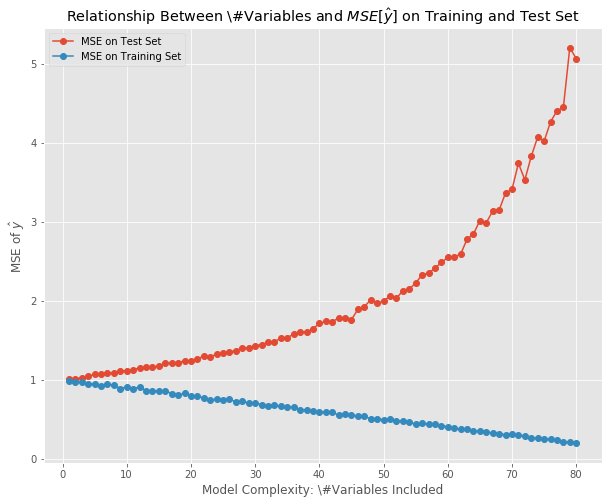

In [5]:
np.random.seed(90)
# run simulation
dim_range, mse_path_test, mse_path_train = lr_high_dimensions(
    range(1,81), 
    np.array([4]+79*[0]).reshape(80,1), 
    n_epochs=100,
    n_sample=1100, 
    test_portion=10/11)

# plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(dim_range, mse_path_test, 'o-')
ax.plot(dim_range, mse_path_train, 'o-')
ax.set_xlabel('Model Complexity: \#Variables Included')
ax.set_ylabel('MSE of $\hat{y}$')
ax.set_title('Relationship Between \#Variables and $MSE[\hat{y}]$ on Training and Test Set')
ax.legend(('MSE on Test Set', 'MSE on Training Set'))

## 4. Exponential Prediction

In [33]:
np.random.seed(42)
n_sample = 1000
y = exponential(1, n_sample)
y_pred_mean = np.ones(n_sample)
y_pred_med = np.ones(n_sample) * np.log(2)
mean_squared_error(y, y_pred_mean), mean_squared_error(y, y_pred_med)

(0.94558562609916719, 1.022871024128073)

In [34]:
mean_absolute_error(y, y_pred_mean), mean_absolute_error(y, y_pred_med)

(0.73302558820985386, 0.68460817591549794)

The mean squared error prefers the mean estimator, while the mean absolute error metric prefers the median estimator

In [ ]:
def fit_naive_bayes(X_train, y_train):
    n, d = X_train.shape
    print('Fitting Naive Bayes...')
    prior_0 = np.log(np.sum(y_train == 0)/n)
    print('log P(y=0) =', prior_0)
    logp00 = bernoulli_logp(
        bernoulli_mle(X_train[y_train == 0,0]))
    logp01 = gaussian_logp(
        *gaussian_mle(X_train[y_train == 0,1]))
    logp02 = gaussian_logp(
        *gaussian_mle(X_train[y_train == 0,2]))
    prior_1 = np.log(np.sum(y_train == 1)/n)
    
    print('log P(y=1) =', prior_1)
    

    
    logp10 = bernoulli_logp(
        bernoulli_mle(X_train[y_train == 1,0]))
    logp11 = gaussian_logp(
        *gaussian_mle(X_train[y_train == 1,1]))
    logp12 = gaussian_logp(
        *gaussian_mle(X_train[y_train == 1,2]))
    
    posterior_0 = lambda x: prior_0 + logp00(
        x[0]) + logp01(x[1]) + logp02(x[2])
    posterior_1 = lambda x: prior_1 + logp10(
        x[0]) + logp11(x[1]) + logp12(x[2])
    return posterior_0, posterior_1
        
def predict(X_test, posterior_0, posterior_1,
            rtype='class'):
    pred = np.zeros(len(X_test))
    for i, row in enumerate(X_test):
        l1 = posterior_1(row)
        l0 = posterior_0(row)
        if rtype == 'class':
            pred[i] = 1 if l1 > l0 else 0
        elif rtype == 'score':
            pred[i] = l1 - l0
    return pred